In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
test_data = pd.read_csv('/content/drive/MyDrive/us_patent/us-patent-phrase-to-phrase-matching/test.csv')
test_data.head()

,id,anchor,target,context
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02
1,09e418c93a776564,adjust gas flow,altering gas flow,F23
2,36baf228038e314b,lower trunnion,lower locating,B60
3,1f37ead645e7f0c8,cap component,upper portion,D06
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04


In [ ]:
data = pd.read_csv("/content/drive/MyDrive/us_patent/us-patent-phrase-to-phrase-matching/train.csv")
data.head()

,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00


In [ ]:
data.drop(columns=['id'], inplace=True)
data.head()

,anchor,target,context,score
0,abatement,abatement of pollution,A47,0.50
1,abatement,act of abating,A47,0.75
2,abatement,active catalyst,A47,0.25
3,abatement,eliminating process,A47,0.50
4,abatement,forest region,A47,0.00


In [ ]:
data['anchor'].value_counts()

component composite coating              152
sheet supply roller                      150
source voltage                           140
perfluoroalkyl group                     136
el display                               135
                                        ... 
plug nozzle                                2
shannon                                    2
dry coating composition1                   2
peripheral nervous system stimulation      1
conduct conducting material                1
Name: anchor, Length: 733, dtype: int64

In [ ]:
data.describe()

,score
count,36473.000000
mean,0.362062
std,0.258335
min,0.000000
25%,0.250000
50%,0.250000
75%,0.500000
max,1.000000


In [ ]:
data['context'].value_counts()

H01    2186
H04    2177
G01    1812
A61    1477
F16    1091
       ... 
B03      47
F17      33
B31      24
A62      23
F26      18
Name: context, Length: 106, dtype: int64

In [ ]:
from math import log
log(106,2)

6.727920454563199

In [ ]:
import itertools
arr1 = [[0,1],[1,0],[1,1],[0,0]]
encoded_labels_raw = []
for v in itertools.product(arr1, repeat=4):
  encoded_labels_raw.append(v)

In [ ]:
encoded_labels = []
for i in encoded_labels_raw:
  encoded_labels.append(list(np.append(i[0],i[1:])))

In [ ]:
encoded_labels.__len__()

256

In [ ]:
import random
random.shuffle(encoded_labels)

In [ ]:
unique_context_items = list(set(list(np.array(list(data.context.items()))[:,1])))

In [ ]:
unique_context_items.__len__()

106

In [ ]:
keys_list = unique_context_items
values_list = encoded_labels
zip_iterator = zip(keys_list, values_list)
encoding_dict = dict(zip_iterator)

In [ ]:
encoded_data = data.copy()
encoded_data['context'] = data['context'].map(encoding_dict)
encoded_data.head()

,anchor,target,context,score
0,abatement,abatement of pollution,"[1, 0, 1, 0, 1, 0, 0, 0]",0.50
1,abatement,act of abating,"[1, 0, 1, 0, 1, 0, 0, 0]",0.75
2,abatement,active catalyst,"[1, 0, 1, 0, 1, 0, 0, 0]",0.25
3,abatement,eliminating process,"[1, 0, 1, 0, 1, 0, 0, 0]",0.50
4,abatement,forest region,"[1, 0, 1, 0, 1, 0, 0, 0]",0.00


In [ ]:
encoded_data = encoded_data.sample(frac=1, random_state=42)
encoded_data.head()

,anchor,target,context,score
33511,transmit alarm,display indicator,"[1, 1, 0, 0, 1, 0, 1, 1]",0.00
18670,locking formation,retaining element,"[1, 1, 0, 1, 1, 0, 0, 0]",0.25
18049,lateral power,transducer,"[1, 0, 1, 1, 1, 1, 0, 0]",0.25
31660,spreader body,spreader,"[0, 0, 1, 1, 0, 1, 0, 1]",0.75
15573,high gradient magnetic separators,magnetic filtration,"[0, 0, 0, 0, 1, 0, 1, 0]",0.50


In [ ]:
encoded_data['score'].value_counts()

0.50    12300
0.25    11519
0.00     7471
0.75     4029
1.00     1154
Name: score, dtype: int64

In [ ]:
score_one_hot = pd.get_dummies(encoded_data, columns=['score'])
score_one_hot = score_one_hot.iloc[:, 3:].to_numpy()
score_one_hot

array([[1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       ...,
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0]], dtype=uint8)

In [ ]:
x = encoded_data['anchor'].value_counts()

In [ ]:
num_samples = []
for i in x:
  num_samples.append(i)

## split data

In [ ]:
anchors = encoded_data.iloc[:,0].to_numpy()
targets = encoded_data.iloc[:,1].to_numpy()
contexts = encoded_data.iloc[:,2].to_list()
y = encoded_data.iloc[:,-1].to_numpy()

## text vectorizer

In [ ]:
anchor_words = [i.split(' ') for i in anchors]
target_words = [i.split(' ') for i in targets]

In [ ]:
all_words = []

for i in anchor_words:
  for j in i:
    all_words.append(j)

for i in target_words:
  for j in i:
    all_words.append(j)

In [ ]:
num_unique_words = set(all_words).__len__()
num_unique_words

8930

In [ ]:
output_seq_len = max([max([len(i.split(' ')) for i in anchors]), max([len(i.split(' ')) for i in targets])])
output_seq_len

15

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens=num_unique_words,
                                    output_sequence_length=output_seq_len,
                                    pad_to_max_tokens=True)

In [ ]:
unique_words = list(set(all_words))
text_vectorizer.adapt(all_words)

## embedding

In [ ]:
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder-large/5")

In [ ]:
pretrained_embedding_layer = hub.KerasLayer(embed,
                                            trainable=False,
                                            input_shape=[],
                                            name="USE")

## char vectorizer/embedding

In [ ]:
def split_chars(text):
  return " ".join(list(text))

In [ ]:
anchors_chars = [split_chars(sequence) for sequence in anchors]
targets_chars = [split_chars(sequence) for sequence in targets]

In [ ]:
all_chars = []

for i in anchors_chars:
    all_chars.append(i)

for i in targets_chars:
    all_chars.append(i)

In [ ]:
output_seq_char_len = int(np.percentile([len(i.split(' ')) for i in targets_chars], 95))
output_seq_char_len

30

In [ ]:
import string
alphabet = string.ascii_lowercase
alphabet, len(alphabet)

('abcdefghijklmnopqrstuvwxyz', 26)

In [ ]:
NUM_CHAR_TOKENS = len(alphabet)+2 #add 2 for space and OOV(out of vocabulary, '[UNK]') token

char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    pad_to_max_tokens=True,
                                    name="char_vectorizer")

char_vectorizer.adapt(all_chars)

In [ ]:
char_vocab = char_vectorizer.get_vocabulary()

In [ ]:
char_embed = tf.keras.layers.Embedding(input_dim=len(char_vocab),
                                       output_dim=32,
                                       name="char_embed")

# REGRESSION

# Preparing datasets

In [ ]:
len(anchors)*0.2

7294.6

In [ ]:
train_word_anchors, val_word_anchors = anchors[:-int(len(anchors)*0.2)], anchors[-int(len(anchors)*0.2):]
train_word_targets, val_word_targets = targets[:-int(len(targets)*0.2)], targets[-int(len(targets)*0.2):]

train_char_anchors, val_char_anchors = anchors_chars[:-int(len(anchors_chars)*0.2)], anchors_chars[-int(len(anchors_chars)*0.2):]
train_char_targets, val_char_targets = targets_chars[:-int(len(targets_chars)*0.2)], targets_chars[-int(len(targets_chars)*0.2):]

train_contexts, val_contexts = contexts[:-int(len(contexts)*0.2)], contexts[-int(len(contexts)*0.2):]

y_train, y_val = y[:-int(len(y)*0.2)], y[-int(len(y)*0.2):]

In [ ]:
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_word_anchors, train_word_targets, train_char_anchors, train_char_targets, train_contexts)) 
train_char_token_labels = tf.data.Dataset.from_tensor_slices(y_train) 
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) 
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) 

val_char_token_data = tf.data.Dataset.from_tensor_slices((val_word_anchors, val_word_targets, val_char_anchors, val_char_targets, val_contexts)) 
val_char_token_labels = tf.data.Dataset.from_tensor_slices(y_val)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels)) 
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
anchor_word_inputs = tf.keras.layers.Input(shape=[], dtype="string", name="anchor_word_inputs")
embedded_anchor_tokens = pretrained_embedding_layer(anchor_word_inputs)
lstm_word1 = tf.keras.layers.LSTM(64, return_sequences=True)(tf.expand_dims(embedded_anchor_tokens, axis=1))
lstm_word2 = tf.keras.layers.LSTM(64)(lstm_word1)
anchor_word_output = tf.keras.layers.Dense(128, activation="relu")(lstm_word2)
anchor_word_model = tf.keras.Model(inputs=anchor_word_inputs,
                             outputs=anchor_word_output,
                             name="anchor_word_model")

target_word_inputs = tf.keras.layers.Input(shape=[], dtype="string", name="target_word_inputs")
embedded_target_tokens = pretrained_embedding_layer(target_word_inputs)
lstm_token1 = tf.keras.layers.LSTM(64, return_sequences=True)(tf.expand_dims(embedded_target_tokens, axis=1))
lstm_token2 = tf.keras.layers.LSTM(64)(lstm_token1)
target_word_output = tf.keras.layers.Dense(128, activation="relu")(lstm_token2)
target_word_model = tf.keras.Model(inputs=target_word_inputs,
                                   outputs=target_word_output,
                                   name="target_word_model")

word_concat = tf.keras.layers.Concatenate(name="word_hybrid")([anchor_word_model.output, target_word_model.output])
word_hybrid_dense_output = tf.keras.layers.Dense(128, activation="relu")(word_concat)
dropout_1 = tf.keras.layers.Dropout(0.2)(word_hybrid_dense_output)

anchor_char_inputs = tf.keras.layers.Input(shape=(1,), dtype="string", name="anchor_char_inputs")
vectorized_anchor_characters = char_vectorizer(anchor_char_inputs)
embedded_anchor_chars = char_embed(vectorized_anchor_characters)
anchor_char_bi_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))(embedded_anchor_chars)
anchor_char_model= tf.keras.Model(inputs=anchor_char_inputs,
                                  outputs=anchor_char_bi_lstm,
                                  name="anchor_char_model")

target_char_inputs = tf.keras.layers.Input(shape=(1,), dtype="string", name="target_char_inputs")
vectorized_target_characters = char_vectorizer(target_char_inputs)
embedded_target_chars = char_embed(vectorized_target_characters)
target_char_bi_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))(embedded_target_chars)
target_char_model= tf.keras.Model(inputs=target_char_inputs,
                                  outputs=target_char_bi_lstm,
                                  name="target_char_model")

char_concat = tf.keras.layers.Concatenate(name="char_hybrid")([anchor_char_model.output, target_char_model.output])
char_hybrid_dense_output = tf.keras.layers.Dense(128, activation="relu")(char_concat)
dropout_2 = tf.keras.layers.Dropout(0.2)(char_hybrid_dense_output)

context_inputs = tf.keras.layers.Input(shape=(8,), dtype=tf.float32, name="context_inputs")
context_output = tf.keras.layers.Dense(32, activation="relu")(context_inputs) 
context_model = tf.keras.Model(inputs=context_inputs,
                               outputs=context_output,
                               name="context_model")

tribrid_concat = tf.keras.layers.Concatenate(name="tribrid_concat")([dropout_1,
                                                                     dropout_2,
                                                                     context_model.output])

dropout_3 = tf.keras.layers.Dropout(0.2)(tribrid_concat)

output_layer = tf.keras.layers.Dense(1, activation="sigmoid", name="output_layer")(dropout_3)

model = tf.keras.Model(inputs=[anchor_word_model.input,
                               target_word_model.input,
                               anchor_char_model.input,
                               target_char_model.input,
                               context_model.input],
                        outputs=output_layer,
                        name="tribrid_model")

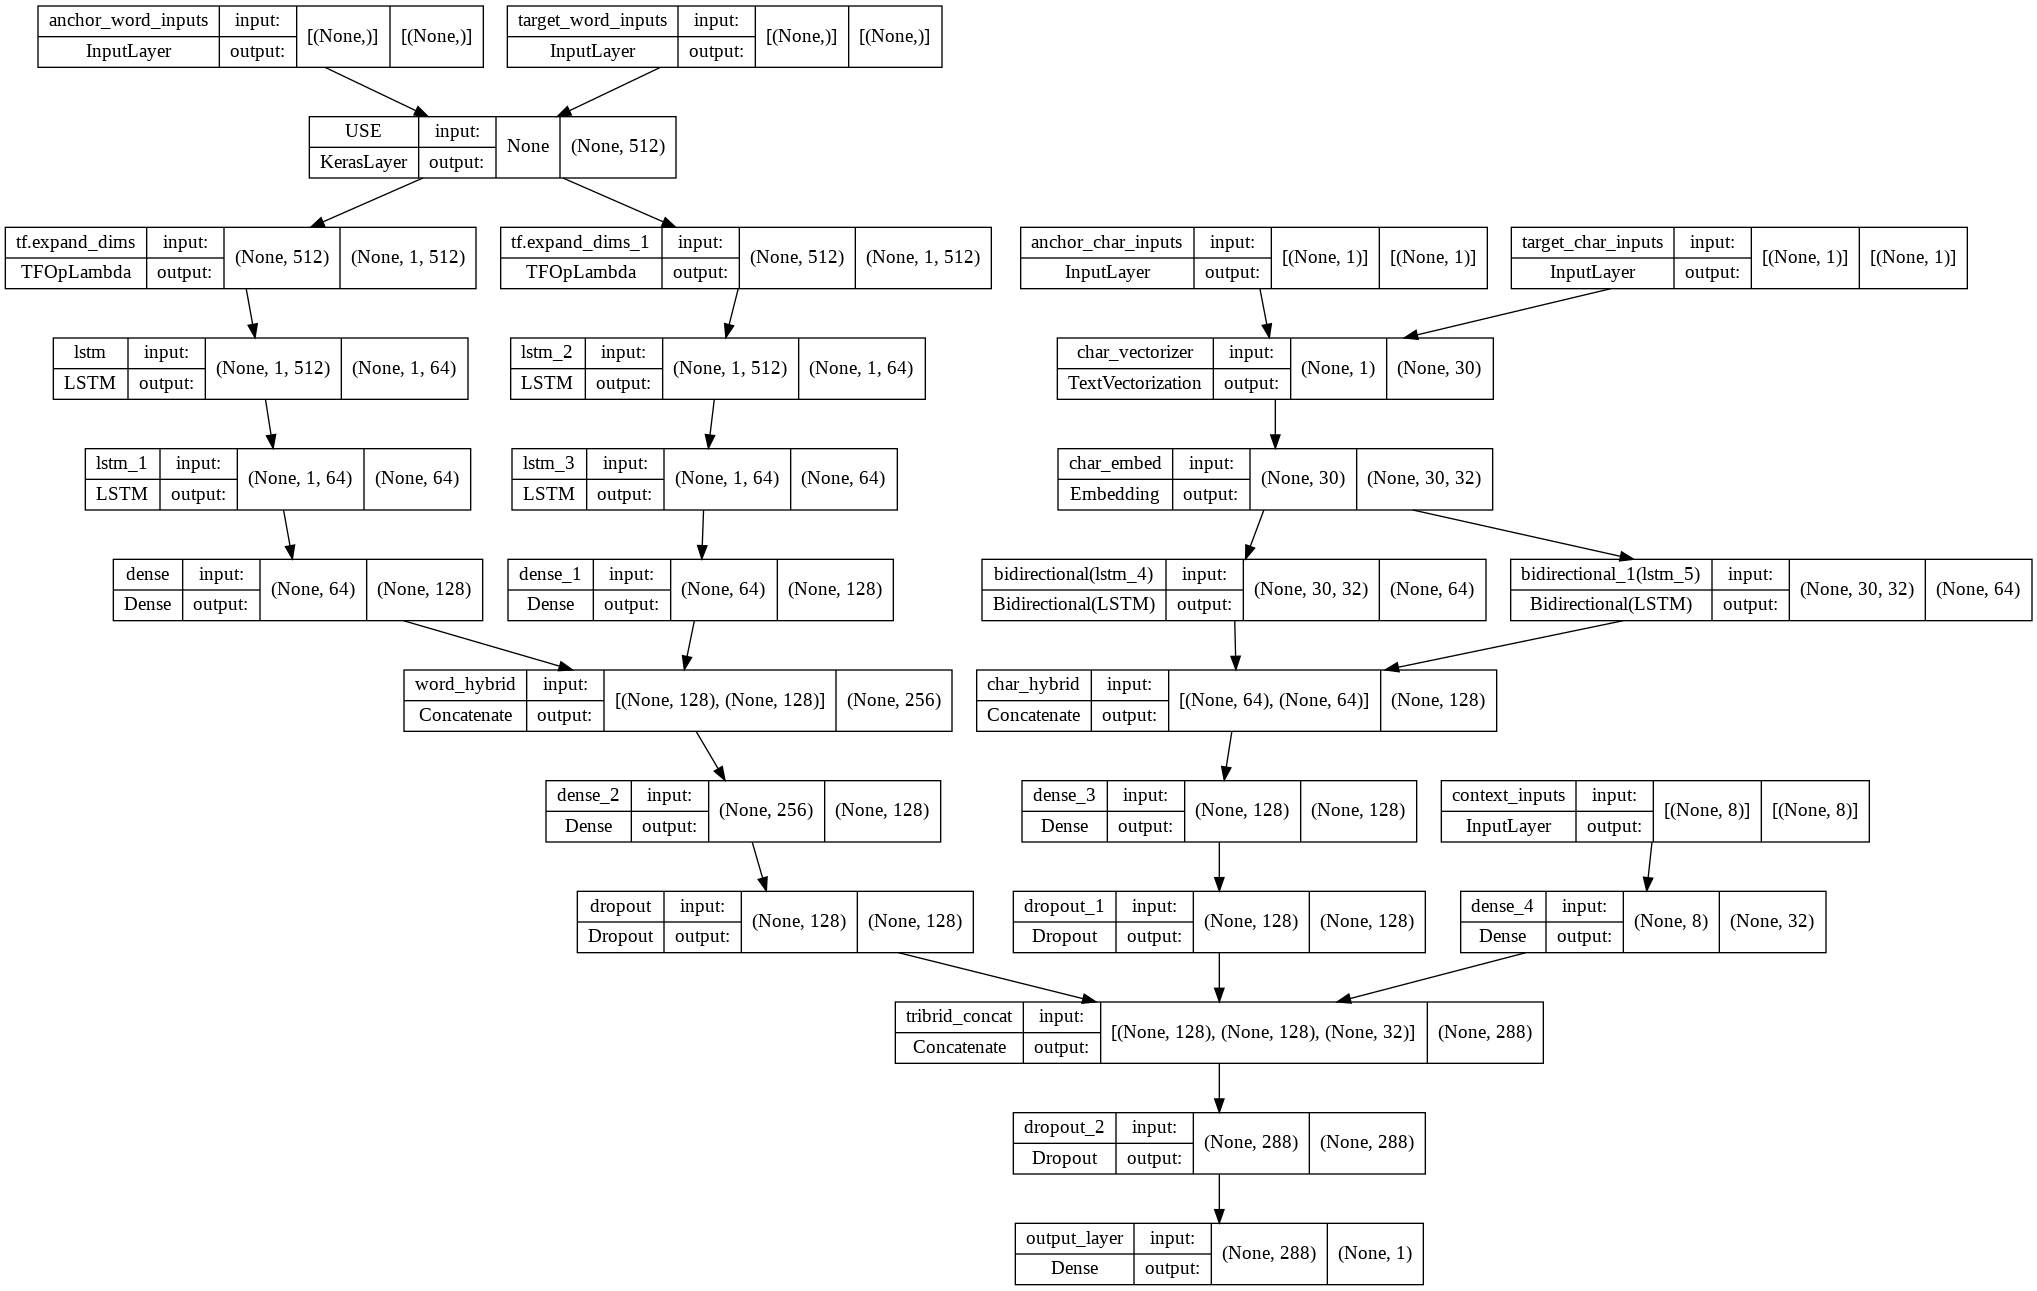

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

In [ ]:
model.compile(loss=tf.keras.losses.mean_squared_error,
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              metrics=['mae'])

In [ ]:
model_history = model.fit(train_char_token_dataset,
                          epochs = 30,
                          validation_data = val_char_token_dataset)

Epoch 1/30
912/912 [==============================] - 107s 88ms/step - loss: 0.0589 - mae: 0.1946 - val_loss: 0.0547 - val_mae: 0.1838
Epoch 2/30
912/912 [==============================] - 70s 76ms/step - loss: 0.0513 - mae: 0.1785 - val_loss: 0.0504 - val_mae: 0.1754
Epoch 3/30
912/912 [==============================] - 70s 77ms/step - loss: 0.0449 - mae: 0.1643 - val_loss: 0.0488 - val_mae: 0.1700
Epoch 4/30
912/912 [==============================] - 69s 76ms/step - loss: 0.0397 - mae: 0.1529 - val_loss: 0.0496 - val_mae: 0.1708
Epoch 5/30
912/912 [==============================] - 72s 79ms/step - loss: 0.0350 - mae: 0.1419 - val_loss: 0.0500 - val_mae: 0.1693
Epoch 6/30
912/912 [==============================] - 71s 78ms/step - loss: 0.0318 - mae: 0.1349 - val_loss: 0.0530 - val_mae: 0.1718
Epoch 7/30
912/912 [==============================] - 74s 81ms/step - loss: 0.0295 - mae: 0.1294 - val_loss: 0.0517 - val_mae: 0.1691
Epoch 8/30
912/912 [==============================] - 71s 77m

In [ ]:
def prepare_sample(sample_num):
  return [val_word_anchors[sample_num],
          val_word_targets[sample_num],
          val_char_anchors[sample_num],
          val_char_targets[sample_num],
          val_contexts[sample_num]]


In [ ]:
val_preds = model.predict(val_char_token_dataset)

In [ ]:
def compare(num_sample):
  print(f'Predicted: {val_preds[num_sample]}')
  print('----------------------')
  print(f'Real: {y_val[num_sample]}')

# CLASSIFICATION

In [ ]:
train_word_anchors, val_word_anchors = anchors[:-int(len(anchors)*0.2)], anchors[-int(len(anchors)*0.2):]
train_word_targets, val_word_targets = targets[:-int(len(targets)*0.2)], targets[-int(len(targets)*0.2):]

train_char_anchors, val_char_anchors = anchors_chars[:-int(len(anchors_chars)*0.2)], anchors_chars[-int(len(anchors_chars)*0.2):]
train_char_targets, val_char_targets = targets_chars[:-int(len(targets_chars)*0.2)], targets_chars[-int(len(targets_chars)*0.2):]

train_contexts, val_contexts = contexts[:-int(len(contexts)*0.2)], contexts[-int(len(contexts)*0.2):]

y_train_one_hot, y_val_one_hot = score_one_hot[:-int(len(y)*0.2)], score_one_hot[-int(len(y)*0.2):]

In [ ]:
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_word_anchors, train_word_targets, train_char_anchors, train_char_targets, train_contexts)) 
train_char_token_labels = tf.data.Dataset.from_tensor_slices(y_train_one_hot) 
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) 
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) 

val_char_token_data = tf.data.Dataset.from_tensor_slices((val_word_anchors, val_word_targets, val_char_anchors, val_char_targets, val_contexts)) 
val_char_token_labels = tf.data.Dataset.from_tensor_slices(y_val_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels)) 
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
anchor_word_inputs = tf.keras.layers.Input(shape=[], dtype="string", name="anchor_word_inputs")
embedded_anchor_tokens = pretrained_embedding_layer(anchor_word_inputs)
lstm_word1 = tf.keras.layers.LSTM(64, return_sequences=True)(tf.expand_dims(embedded_anchor_tokens, axis=1))
lstm_word2 = tf.keras.layers.LSTM(64)(lstm_word1)
anchor_word_output = tf.keras.layers.Dense(128, activation="relu")(lstm_word2)
anchor_word_model = tf.keras.Model(inputs=anchor_word_inputs,
                             outputs=anchor_word_output,
                             name="anchor_word_model")

target_word_inputs = tf.keras.layers.Input(shape=[], dtype="string", name="target_word_inputs")
embedded_target_tokens = pretrained_embedding_layer(target_word_inputs)
lstm_token1 = tf.keras.layers.LSTM(64, return_sequences=True)(tf.expand_dims(embedded_target_tokens, axis=1))
lstm_token2 = tf.keras.layers.LSTM(64)(lstm_token1)
target_word_output = tf.keras.layers.Dense(128, activation="relu")(lstm_token2)
target_word_model = tf.keras.Model(inputs=target_word_inputs,
                                   outputs=target_word_output,
                                   name="target_word_model")

word_concat = tf.keras.layers.Concatenate(name="word_hybrid")([anchor_word_model.output, target_word_model.output])
word_hybrid_dense_output = tf.keras.layers.Dense(128, activation="relu")(word_concat)
dropout_1 = tf.keras.layers.Dropout(0.2)(word_hybrid_dense_output)

anchor_char_inputs = tf.keras.layers.Input(shape=(1,), dtype="string", name="anchor_char_inputs")
vectorized_anchor_characters = char_vectorizer(anchor_char_inputs)
embedded_anchor_chars = char_embed(vectorized_anchor_characters)
anchor_char_bi_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))(embedded_anchor_chars)
anchor_char_model= tf.keras.Model(inputs=anchor_char_inputs,
                                  outputs=anchor_char_bi_lstm,
                                  name="anchor_char_model")

target_char_inputs = tf.keras.layers.Input(shape=(1,), dtype="string", name="target_char_inputs")
vectorized_target_characters = char_vectorizer(target_char_inputs)
embedded_target_chars = char_embed(vectorized_target_characters)
target_char_bi_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))(embedded_target_chars)
target_char_model= tf.keras.Model(inputs=target_char_inputs,
                                  outputs=target_char_bi_lstm,
                                  name="target_char_model")

char_concat = tf.keras.layers.Concatenate(name="char_hybrid")([anchor_char_model.output, target_char_model.output])
char_hybrid_dense_output = tf.keras.layers.Dense(128, activation="relu")(char_concat)
dropout_2 = tf.keras.layers.Dropout(0.2)(char_hybrid_dense_output)

context_inputs = tf.keras.layers.Input(shape=(8,), dtype=tf.float32, name="context_inputs")
context_output = tf.keras.layers.Dense(32, activation="relu")(context_inputs)
context_model = tf.keras.Model(inputs=context_inputs,
                               outputs=context_output,
                               name="context_model")

tribrid_concat = tf.keras.layers.Concatenate(name="tribrid_concat")([dropout_1,
                                                                     dropout_2,
                                                                     context_model.output])

dropout_3 = tf.keras.layers.Dropout(0.2)(tribrid_concat)

output_layer = tf.keras.layers.Dense(5, activation="softmax", name="output_layer")(dropout_3)

model = tf.keras.Model(inputs=[anchor_word_model.input,
                               target_word_model.input,
                               anchor_char_model.input,
                               target_char_model.input,
                               context_model.input],
                        outputs=output_layer,
                        name="tribrid_model")

In [ ]:
model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [ ]:
model_history = model.fit(train_char_token_dataset,
                          epochs = 30,
                          validation_data = val_char_token_dataset)

# Deep Similarity Model

In [ ]:
anchor_lstm_input = tf.keras.layers.Input(shape=[], dtype='string')
embedded_anchors = pretrained_embedding_layer(anchor_lstm_input)
anchor_lstm = tf.keras.layers.LSTM(64)(tf.expand_dims(embedded_anchors,axis=-1))
anchor_lstm_model = tf.keras.Model(inputs=anchor_lstm_input, outputs=anchor_lstm, name='anchor_lstm_model')

anchor_cnn_input = tf.keras.layers.Input(shape=[], dtype='string')
embedded_cnn_anchors = pretrained_embedding_layer(anchor_cnn_input)
anchor_conv1 = tf.keras.layers.Conv1D(64,2)(tf.expand_dims(embedded_cnn_anchors,axis=-1))
anchor_drop1 = tf.keras.layers.Dropout(0.2)(anchor_conv1)
anchor_conv2 = tf.keras.layers.Conv1D(64,2)(anchor_drop1)
gmp_anchor = tf.keras.layers.GlobalMaxPooling1D()(anchor_conv2)
anchor_drop2 = tf.keras.layers.Dropout(0.2)(gmp_anchor)
anchor_dense = tf.keras.layers.Dense(128, activation='relu')(anchor_drop2)
anchor_drop3 = tf.keras.layers.Dropout(0.2)(anchor_dense)
anchor_bn = tf.keras.layers.BatchNormalization()(anchor_drop3)
anchor_conv_model = tf.keras.Model(inputs=anchor_cnn_input, outputs=anchor_bn, name='anchor_conv_model')
######################################################################
target_lstm_input = tf.keras.layers.Input(shape=[], dtype='string')
embedded_targets = pretrained_embedding_layer(target_lstm_input)
target_lstm = tf.keras.layers.LSTM(64)(tf.expand_dims(embedded_targets,axis=-1))
target_lstm_model = tf.keras.Model(inputs=target_lstm_input, outputs=target_lstm, name='target_lstm_model')

target_cnn_input = tf.keras.layers.Input(shape=[], dtype='string')
embedded_cnn_targets = pretrained_embedding_layer(target_cnn_input)
target_conv1 = tf.keras.layers.Conv1D(64,2)(tf.expand_dims(embedded_cnn_targets,axis=-1))
target_drop1 = tf.keras.layers.Dropout(0.2)(target_conv1)
target_conv2 = tf.keras.layers.Conv1D(64,2)(target_drop1)
gmp_target = tf.keras.layers.GlobalMaxPooling1D()(target_conv2)
target_drop2 = tf.keras.layers.Dropout(0.2)(gmp_target)
target_dense = tf.keras.layers.Dense(128, activation='relu')(target_drop2)
target_drop3 = tf.keras.layers.Dropout(0.2)(target_dense)
target_bn = tf.keras.layers.BatchNormalization()(target_drop3)
target_conv_model = tf.keras.Model(inputs=target_cnn_input, outputs=target_bn, name='target_conv_model')

concat = tf.keras.layers.Concatenate()([anchor_lstm_model.output,
                                        anchor_conv_model.output,
                                        target_lstm_model.output,
                                        target_conv_model.output])

dense1 = tf.keras.layers.Dense(128, activation='relu')(concat)
output = tf.keras.layers.Dense(5, activation='softmax')(dense1)

similarity_model = tf.keras.Model(inputs=[anchor_lstm_model.input,
                                          anchor_conv_model.input,
                                          target_lstm_model.input,
                                          target_conv_model.input],
                                  outputs=output,
                                  name='similarity_model')

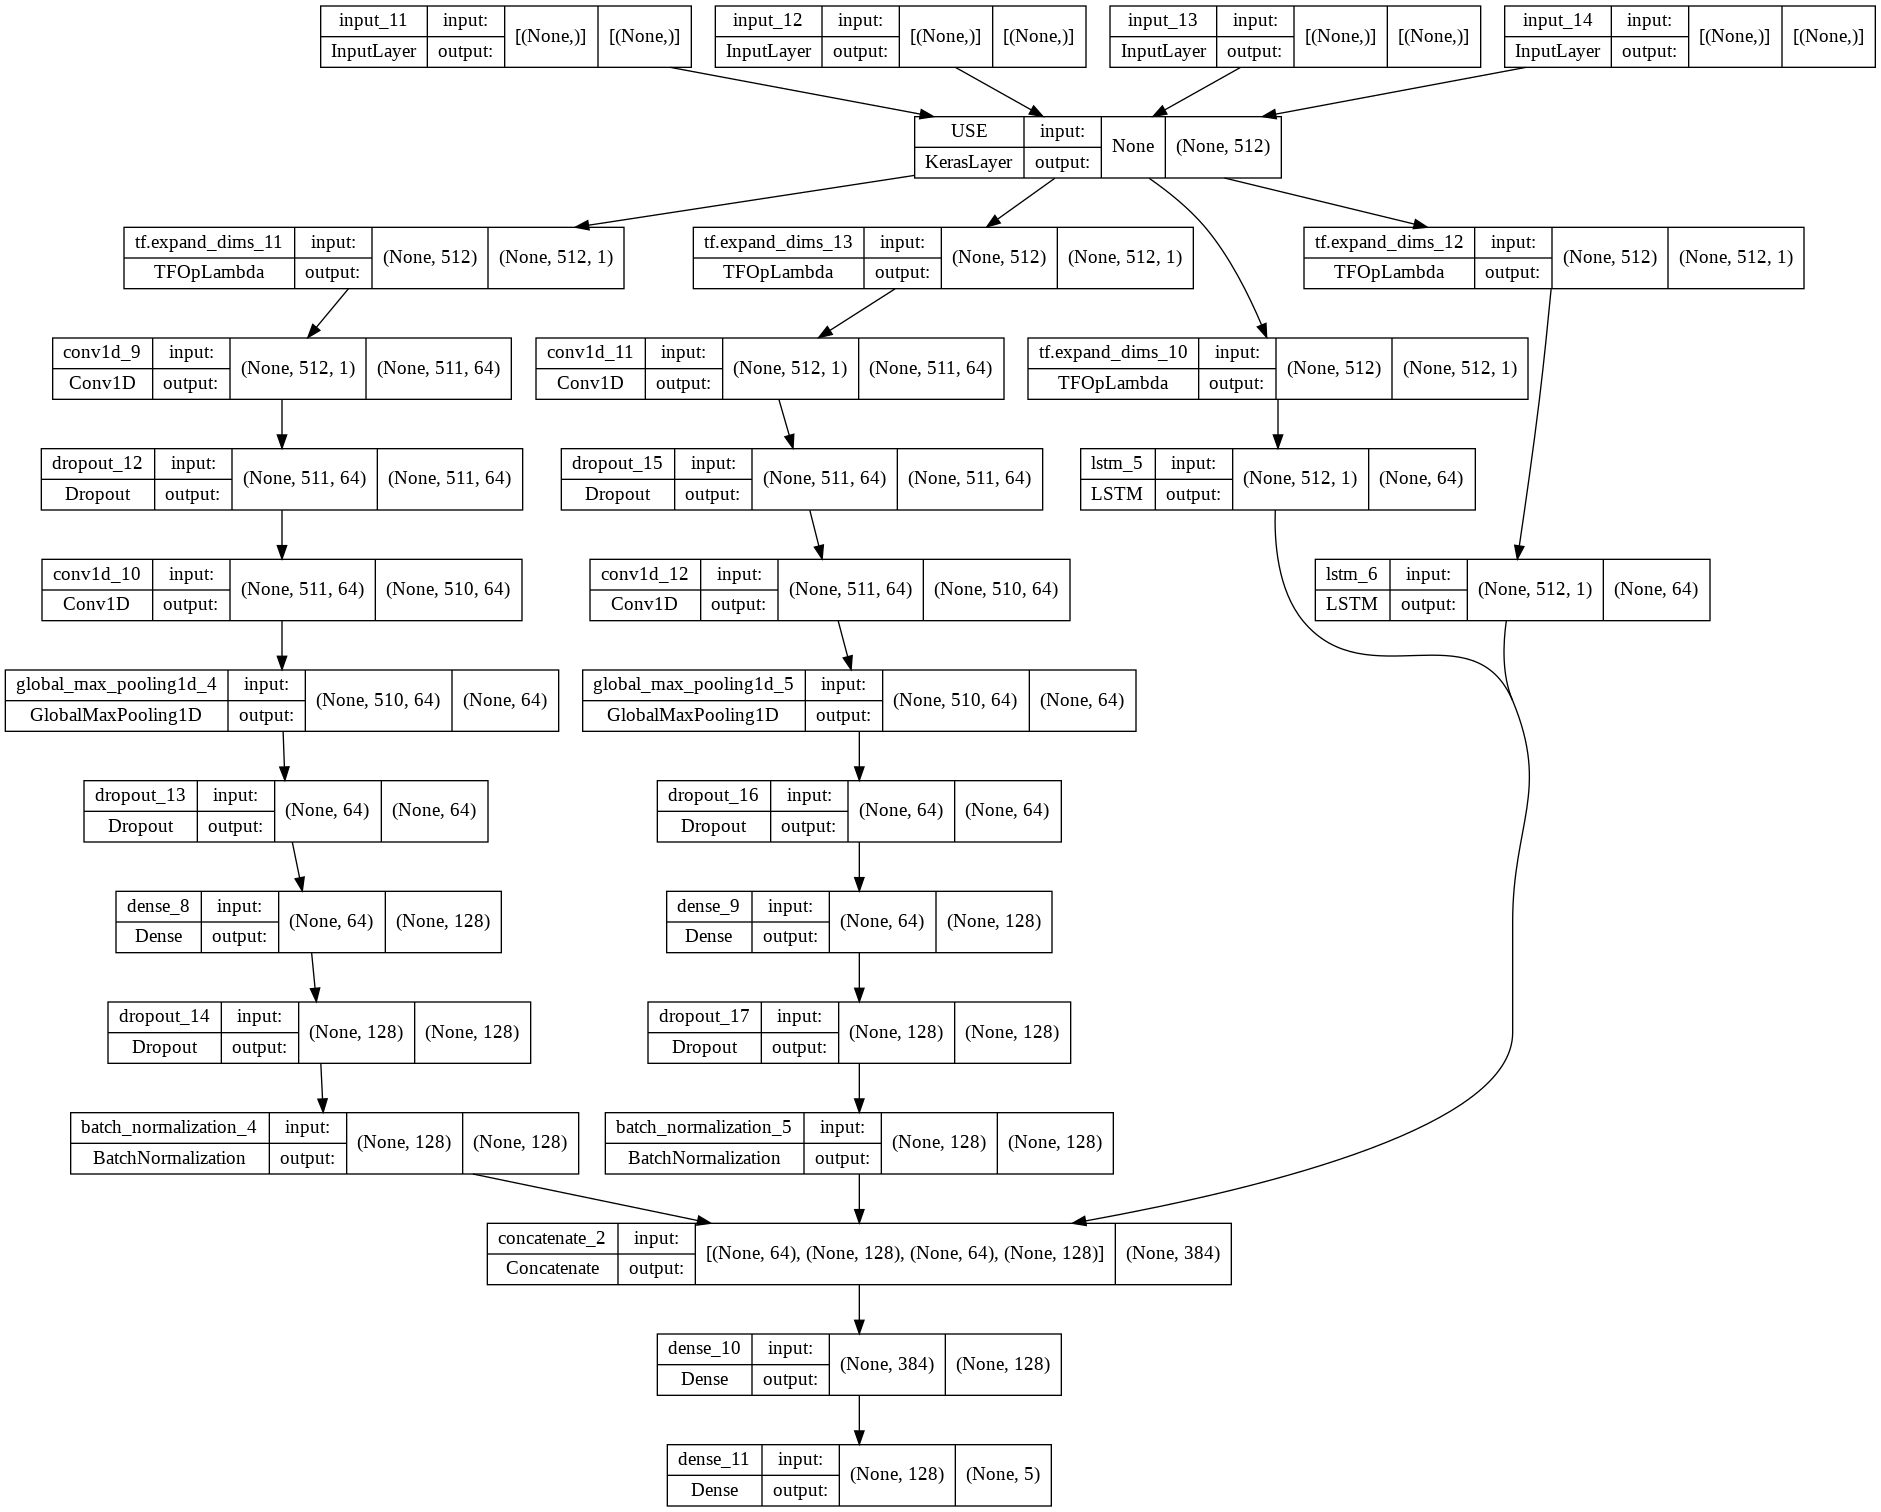

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(similarity_model, show_shapes=True)

In [ ]:
### DATASET OLUŞTUR ###
'Features = [anchors, targets]'
'Labels = [scores_one_hot]'

'Labels = [scores_one_hot]'

In [ ]:
sm_train_data = tf.data.Dataset.from_tensor_slices((train_word_anchors, train_word_anchors, train_word_targets, train_word_targets)) 
sm_train_labels = tf.data.Dataset.from_tensor_slices(y_train_one_hot)
sm_train_dataset = tf.data.Dataset.zip((sm_train_data, sm_train_labels))
sm_train_dataset = sm_train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

sm_val_data = tf.data.Dataset.from_tensor_slices((val_word_anchors, val_word_anchors, val_word_targets, val_word_targets))
sm_val_labels = tf.data.Dataset.from_tensor_slices(y_val_one_hot)
sm_val_dataset = tf.data.Dataset.zip((sm_val_data, sm_val_labels))
sm_val_dataset = sm_val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_word_anchors.shape, train_word_targets.shape, val_word_anchors.shape, val_word_targets.shape

((29179,), (29179,), (7294,), (7294,))

In [ ]:
y_train_one_hot.shape, y_val_one_hot.shape

((29179, 5), (7294, 5))

In [ ]:
similarity_model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Nadam(),
              metrics=['accuracy'])

In [ ]:
similarity_model_history = similarity_model.fit(sm_train_dataset,
                                                batch_size=2048,
                                                epochs=30,
                                                validation_data=sm_val_dataset)